## Word2Vec

A popular model which is able to learn word vectors (also called word embeddings) which capture semantic and syntactic meaning is Word2Vec. It is build upon a neural network architecture and has been presented by [Mikolov et al. (2013)](https://arxiv.org/abs/1301.3781) and [Mikolov et al. (2013)](https://arxiv.org/abs/1310.4546). The model represents every word by a $p$-dimensional vector. In comparison to our example, each real-valued number in a word vector does not have a specific meaning. However, after the model is trained, the vectors will be similar to each other if the words have similar meaning. Two versions of the Word2Vec model exist: (1) the continuous bag of words approach (CBOW), and, (2) the skip-gram (SG) model. For both approaches, we take a look at the surrounding words around a center word. Let us denote $w_j$ as the center word. The surrounding words, we may also call then feature words, are defined by the window size whose length $2 \cdot t$ needs to be chosen by the user. The feature words are up to $t$ words to the left and up to $t$ words to the right of the center word: $w_{j-t}, w_{j-t+1}, ..., w_{j-1}, w_{j+1}, w_{j + t -1}, w_{j + t}$. For instance, given the sentence, "the dog would like a piece of the sandwich", setting the center word "like" and a window size of $4$, the context words are: "dog, would, a, piece". The CBOW model tries to predict the center word by the feature words, the SG model tries to predict feature words, given the center word. 

The easiest way to understand the model is to take a look at a minimal example. So, let's go: First, everything starts with a corpus. Ours consists of three sentences:


In [1]:
from gensim.utils import simple_preprocess

raw_corpus = [
    "I love vanilla ice cream",
    "I love strawberry ice cream",
    "The capitol of Germany is Berlin",
    "The capitol of France is Paris"
]

corpus = [simple_preprocess(doc, min_len = 1) for doc in raw_corpus]
corpus

[['i', 'love', 'vanilla', 'ice', 'cream'],
 ['i', 'love', 'strawberry', 'ice', 'cream'],
 ['the', 'capitol', 'of', 'germany', 'is', 'berlin'],
 ['the', 'capitol', 'of', 'france', 'is', 'paris']]

Next, we build a vocabulary in which each word is mapped to an index.

In [2]:
word2index = dict()
idx = 0
for doc in corpus:
    for word in doc:
        if word in word2index.keys():
            continue
        else:
            word2index[word] = idx
            idx += 1

word2index

{'i': 0,
 'love': 1,
 'vanilla': 2,
 'ice': 3,
 'cream': 4,
 'strawberry': 5,
 'the': 6,
 'capitol': 7,
 'of': 8,
 'germany': 9,
 'is': 10,
 'berlin': 11,
 'france': 12,
 'paris': 13}

### CBOW

The CBOW model is build around a multi-class classification task. One predicts the probabilities for the center word, given the words within the window size: $P \left( w_i | w_{i-t}, w_{i-t+1}, ..., w_{i-1}, w_{i+1}, w_{i + t -1}, w_{i + t} \right) $. Let us denote $\boldsymbol{x}_{j}$ as the one-hot encoded vector for word $j$ where $j$ is the number of the index in the dictionary. The number of categories is equal to the number of words, e.g., $d = 16$. To generate probability predictions, we make use of two matrices $\boldsymbol{W}, \boldsymbol{V}$ whose elements are parameters which need to be trained. Assume a window size of $2$ (so one word to the left and one word to the right) and we start with the sequence "I love vanilla". The feature words and their one-hot encoded vectors, e.g., "I", "vanilla" is represented by $\boldsymbol{x}_{0}, \boldsymbol{x}_{2}$ which can be subsumed in a matrix:

$$\boldsymbol{C}^{(0, 2)} = \begin{pmatrix} \boldsymbol{x}_{0} \\ \boldsymbol{x}_{2} \end{pmatrix}$$

See in the cell below how this looks like for our example:

In [3]:
from torch.nn.functional import one_hot
import torch

# define the number of terms in the lexicon
d = len(word2index.keys())

C_02 = one_hot(torch.LongTensor([0, 2]), num_classes=d)
C_02

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Next, we multiply this matrix with the context word embedding matrix $\boldsymbol{W}$, its first dimension must be equal to $d$, its second dimension $p$ can be set by the user and will define the dimension of word embeddings. Let us set $p=3$ for our example and take a look at an example below whose parameters have been randomly initialized.

In [4]:
# embedding dimension
p = 3

W = torch.nn.Embedding(num_embeddings=d, embedding_dim=p)
W.weight

Parameter containing:
tensor([[-0.4914, -0.9289, -1.3964],
        [-2.0368,  0.0378,  0.4758],
        [-2.3017,  0.4616,  0.2371],
        [ 0.2534,  0.0812, -0.8332],
        [ 0.0471, -0.1035,  2.0873],
        [ 0.1220,  1.1734,  0.9843],
        [-1.1303,  0.0129,  0.7087],
        [ 0.1469, -0.3384, -1.2746],
        [ 0.8244,  0.4985, -0.3488],
        [-1.0278, -1.7970,  1.2963],
        [ 1.1974,  3.0013,  0.5727],
        [ 0.2980,  0.4173, -0.3241],
        [-0.5996, -2.4289,  0.3598],
        [-0.7243, -0.2004,  1.6924]], requires_grad=True)

This can be seen as the weights from the first layer in a neural network whose input are the one-hot context word vectors with dimension $2t \times d$. Each row of this matrix relates to the word embedding for one word if it is used in the window of a center word. Multiplying the one-hot vector input with this matrix basically transforms the one-hot encoded input into numerical representations of the feature words. Let us continue the example below:

In [5]:
c = W(torch.LongTensor([0, 2]))
c

tensor([[-0.4914, -0.9289, -1.3964],
        [-2.3017,  0.4616,  0.2371]], grad_fn=<EmbeddingBackward0>)

Note that we observe row vectors with index numbers $0,2$ because these are the index numbers for our example "I", "vanilla". In order to condense the information of the context words into one vector, one can average or sum these vectors row-wise. Let us build the average and continue with this vector that we denote as the context vector $\boldsymbol{c}$.

In [6]:
c = c.mean(axis = 0)
c

tensor([-1.3966, -0.2336, -0.5797], grad_fn=<MeanBackward1>)

To determine the probabilities for the center words, we multiply this vector with the matrix $\boldsymbol{V}$ which must have dimensionality $p \times d$ and ...

In [7]:
V = torch.nn.Linear(in_features=p, out_features=d, bias = False)
z = V(c)
z

tensor([-0.3393,  0.1479, -0.7807, -0.6148, -0.4243,  0.5064, -0.0057,  0.0852,
         0.0182,  0.0483,  0.4994,  0.2462,  0.2117,  0.2278],
       grad_fn=<SqueezeBackward4>)

...use the softmax function.

In [8]:
prob_w = torch.nn.functional.softmax(z, dim = 0)
prob_w

tensor([0.0483, 0.0786, 0.0310, 0.0367, 0.0443, 0.1125, 0.0674, 0.0738, 0.0690,
        0.0711, 0.1117, 0.0867, 0.0838, 0.0851], grad_fn=<SoftmaxBackward0>)

In our example, the true category would be the word "love" which is represented by the one-hot encoded vector $\boldsymbol{w}_1$ with index $1$. Thus, in order to determine the value of the crossentropy loss function, we calculate the dot product and determine the negative log of this value. 

In [9]:
import numpy as np

-np.log((prob_w @ one_hot(torch.LongTensor([1]), num_classes=d).reshape(d, 1).float()).detach().numpy())

array([2.5436094], dtype=float32)

Let us go through these steps formally:

1. Generate a one-hot encoded context input, given a window length $2t$, $\boldsymbol{C} \in [0, 1]^{2t \times d}$
2. Multiply this with the feature word vector matrix, $\boldsymbol{W} \in \mathbb{R}^{d \times p}$ and aggregate the outcome to a single vector with dimension $p$
3. Multiply this vector with the center word vector matrix $\boldsymbol{V} \in \mathbb{R}^{p \times d}$ and transform the output with the softmax function to probabilities
4. Multiply the probability prediction with the one-hot vector of the center word to determine the loss

This is done for all possible center word context word combinations and gradient descent can be used to update the parameters of $\boldsymbol{W}$ and $\boldsymbol{V}$. After training is finished one usually uses the columns of $\boldsymbol{V}$ as word embeddings where word with index $0$ is represented by the first column, word with index $1$ is represented by the second column and so on. Let us take a look how we could do this by hand using pytorch for our example.

First we generate the samples. Note that sample indices are used to derive the one-hot information for the center words. 

In [10]:
# context length
k = 2
context_indices = [j for j in range(-k, k+1) if j != 0] # 

# generate training samples
sample_words = []
samples = []
for doc in corpus:
    for i in range(k, len(doc) - k):
        center_word = doc[i]
        center_word_idx = word2index[doc[i]]
        context_words = [doc[i + idx] for idx in context_indices]
        context_word_idx = [word2index[doc[i + idx]] for idx in context_indices]
        sample_words.append((context_words, center_word))
        samples.append((context_word_idx, center_word_idx))

print("This is how the training samples look like:")
print(sample_words)
print("")
print("This is how the training samples information is provided:")
print(samples)

This is how the training samples look like:
[(['i', 'love', 'ice', 'cream'], 'vanilla'), (['i', 'love', 'ice', 'cream'], 'strawberry'), (['the', 'capitol', 'germany', 'is'], 'of'), (['capitol', 'of', 'is', 'berlin'], 'germany'), (['the', 'capitol', 'france', 'is'], 'of'), (['capitol', 'of', 'is', 'paris'], 'france')]

This is how the training samples information is provided:
[([0, 1, 3, 4], 2), ([0, 1, 3, 4], 5), ([6, 7, 9, 10], 8), ([7, 8, 10, 11], 9), ([6, 7, 12, 10], 8), ([7, 8, 10, 13], 12)]


Next, we prepare these training samples such they can be inserted into a neural network.

In [11]:
# prepare training examples for a neural network
X = [sample[0] for sample in samples]
y = [sample[1] for sample in samples]

print("Input word index labels for the neural network:")
print(X)
print("")
print("Target word labels for the neural network:")
print(y)

Input word index labels for the neural network:
[[0, 1, 3, 4], [0, 1, 3, 4], [6, 7, 9, 10], [7, 8, 10, 11], [6, 7, 12, 10], [7, 8, 10, 13]]

Target word labels for the neural network:
[2, 5, 8, 9, 8, 12]


Below we train the model. The embedding layer includes word vectors for the feature word embedding matrix $\boldsymbol{W}$ and the linear layer includes word embeddings for center words which is matrix $\boldsymbol{V}$. The model processes every sample as described in detail above and uses gradient descent for the crossentropy loss function. Basically this is a multi-class prediction problem if we define the model as below.

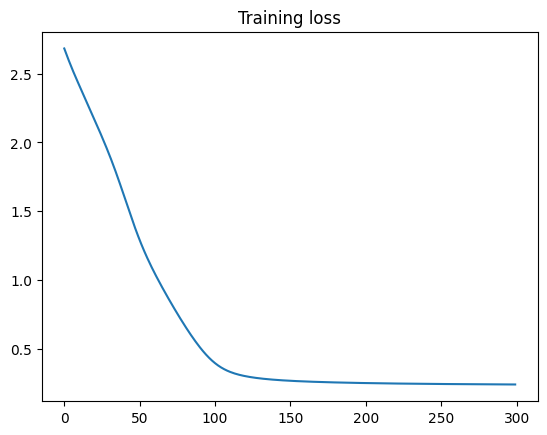

In [12]:
import matplotlib.pylab as plt

# define the neural network architecture
class W2WCBow(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(num_embeddings=d, embedding_dim=p)
        self.linear = torch.nn.Linear(in_features=p, out_features=d, bias = False)

    def forward(self, x):
        e = self.embedding(x)
        e = e.mean(axis = 1)
        z = self.linear(e)
        return z
    
# define an instande of the model class
w2w_cbow = W2WCBow()
w2w_cbow(torch.LongTensor(X))

# define an optimizer and loss
optimizer = torch.optim.Adam(lr = 0.015, params = w2w_cbow.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

losses = []
epochs = 300
for epoch in range(epochs):
    w2w_cbow.train()
    scores = w2w_cbow(torch.tensor(X))
    batch_loss = loss_fn(scores, torch.tensor(y))
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    losses.append(batch_loss.detach().numpy())

# visualize the training loss  
plt.plot(losses)
plt.title("Training loss")
plt.show()

Once training is finished, it makes sense to use center word vectors $\boldsymbol{V}$ as embeddings for our words. However, one may also experiment and can use feature word vectors $\boldsymbol{W}$ or the average vectors of both matrices. Our example is too small to produce high quality embeddings. However if you take a look at the cosine similarity matrix below, you can observe that, e.g., the model learned "vanilla" has a similar meaning to "strawberry" or "berlin" is similar to "paris" which makes sense, given our corpus information.

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

word_embeddings = w2w_cbow.linear.weight.detach().numpy() #w2v_cbow.get_layer("center_vectors").get_weights()[0].transpose()
word_embeddings_df = pd.DataFrame(cosine_similarity(word_embeddings), columns = list(word2index.keys()), index = list(word2index.keys()))
word_embeddings_df

,i,love,vanilla,ice,cream,strawberry,the,capitol,of,germany,is,berlin,france,paris
i,1.000000,0.996721,-0.471677,0.997312,0.993165,-0.427868,0.999743,0.997098,-0.498924,0.019026,0.999614,0.994592,0.178360,0.998903
love,0.996721,1.000000,-0.401183,0.999741,0.999127,-0.368418,0.994650,0.988388,-0.495784,-0.061360,0.998103,0.999686,0.155644,0.999254
vanilla,-0.471677,-0.401183,1.000000,-0.414964,-0.377122,0.937806,-0.491446,-0.519509,0.054633,-0.881882,-0.448989,-0.378606,-0.102790,-0.436041
ice,0.997312,0.999741,-0.414964,1.000000,0.999032,-0.387280,0.995546,0.988961,-0.478787,-0.048545,0.998119,0.998966,0.139539,0.999649
cream,0.993165,0.999127,-0.377122,0.999032,1.000000,-0.357149,0.990443,0.981717,-0.471428,-0.091181,0.994834,0.999274,0.122015,0.997526
strawberry,-0.427868,-0.368418,0.937806,-0.387280,-0.357149,1.000000,-0.445751,-0.455241,-0.249579,-0.785825,-0.402592,-0.345331,0.247153,-0.402701
the,0.999743,0.994650,-0.491446,0.995546,0.990443,-0.445751,1.000000,0.998225,-0.496201,0.041690,0.998807,0.991982,0.181160,0.997688
capitol,0.997098,0.988388,-0.519509,0.988961,0.981717,-0.455241,0.998225,1.000000,-0.529649,0.081465,0.995858,0.985162,0.229967,0.992506
of,-0.498924,-0.495784,0.054633,-0.478787,-0.471428,-0.249579,-0.496201,-0.529649,1.000000,0.075361,-0.513205,-0.503996,-0.913026,-0.485786
germany,0.019026,-0.061360,-0.881882,-0.048545,-0.091181,-0.785825,0.041690,0.081465,0.075361,1.000000,-0.004710,-0.084911,0.162211,-0.023875


Note that words in the beginning and end of the sentences are ignored in our example which causes problems for such a small corpus but usually is not problematic for a large corpus. Given a large collection of documents, common embedding dimension $p$ are rather in the hundreds as in comparison to our example.

**How does the model learn similar meaning?**

The description from above explains the technical process, however, to understand how words with similar meaning get similar word vectors it may help to explain this in a more intuitive (and slightly technical) way. 

Let us take a look at the two sentences:

* I love vanilla ice cream
* I love strawberry ice cream

Using two words to the left and to the right, we would generate a vector which represents the surrounding "I, love" and "ice cream". Let us denote this vector by $\mathbf{w}$. This vector is going to be multiplied with every possible word vector $\mathbf{v}^{(I)}, \mathbf{v}^{(love)}, \mathbf{v}^{(vanilla)}, \mathbf{v}^{(strawberry)}, \mathbf{v}^{(ice)}, \mathbf{v}^{(cream)}$. Each multiplication is the dot product of $\mathbf{w}$ and one of the word vectors. The result is a real-valued number, if it helps denote it as a score. The higher the score the higher the probability prediction for the word. In our example the true categories are "vanilla" and "strawberry". This means after some training, the vectors for the corresponding words create high values for their dot products: $\mathbf{w}^T \mathbf{v}^{(vanilla)}$ and $\mathbf{w}^T \mathbf{v}^{(strawberry)}$. As the vector from the words in the window around the center words $\mathbf{w}$ is the same for both calculations. High values for both dot products can only be generated if $\mathbf{v}^{(vanilla)}$ and $\mathbf{v}^{(strawberry)}$ are similar...and this is how the magic happens.

Take a look below. For our trained model the aggregated vector for the window "I love --- ice cream", is given by:

In [38]:
feature_vector = w2w_cbow.embedding(torch.tensor([[0, 1, 3, 4]])).mean(axis = 1).detach().numpy()[0]
feature_vector

array([-2.2831728,  0.9735688, -2.3843215], dtype=float32)

The trained vanilla vector (from the center word matrix) is:

In [15]:
vanilla_vector = w2w_cbow.linear.weight[2].detach().numpy()
vanilla_vector

array([-1.2944906 ,  0.33643892, -1.095367  ], dtype=float32)

The one for strawberry is:

In [16]:
strawberry_vector = w2w_cbow.linear.weight[5].detach().numpy()
strawberry_vector

array([-0.8498976,  0.3234474, -1.527666 ], dtype=float32)

All three vectors share similarity in sign and value. The scores (dot products) are:


In [17]:
feature_vector @ vanilla_vector

5.894799

In [18]:
feature_vector @ strawberry_vector

5.897808

If we change the similarity between the "vanilla" and "strawberry" representation by, e.g., changing the sign for the last number of the strawberry vector.

In [19]:
strawberry_vector[2] = -strawberry_vector[2]
strawberry_vector

array([-0.8498976,  0.3234474,  1.527666 ], dtype=float32)

The score for it is decreased which would reduce the probability prediction for seeing the word "strawberry", given the window "I love --- ice cream".

In [20]:
feature_vector @ strawberry_vector

-1.3870852

This does not make sense as "vanilla" and "strawberry" are equally likely in our example. Thus, the more similar vector after training is more reasonable and more in line with the observed corpus.

### SG
The figure below visualizes the CBOW and the SG model. While CBOW uses words in the window arount the center word to predict the center word, SG uses the center word to predict words within the window size. Thus, the prediction simplifies to $P \left( w_l | w_i \right)$ for any feature word $w_l \in \lbrace w_{i-t}, w_{i-t+1}, ..., w_{i-1}, w_{i+1}, w_{i + t -1}, w_{i + t}  \rbrace$. As before, we use train two parameter matrices $\boldsymbol{W}, \boldsymbol{V}$, however, this time $\boldsymbol{W}$ represents word embeddings for center words and $\boldsymbol{V}$ word embeddings for context words.

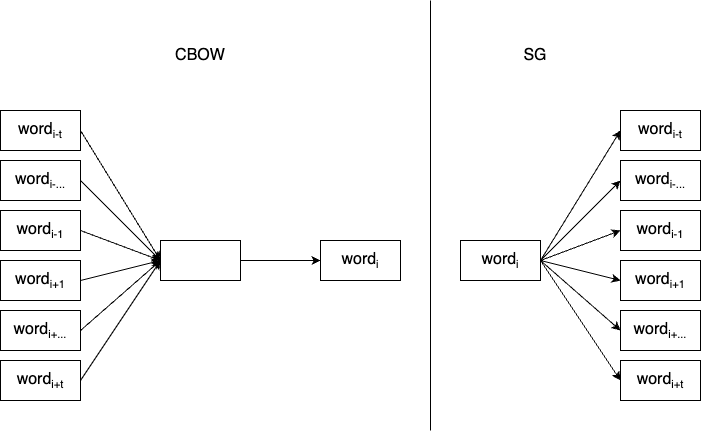

In [21]:
from IPython.display import Image
Image(filename='cbow_sg.png') 

Furthermore, training samples are reduced to one center word and one context word at a time (note this could also be transformed to a multi-label classifiction which should lead to the same or very similar results). Besides these differences, the training process is rather similar. First, we build training samples:

In [22]:
# number of terms in the lexicon
d = len(word2index.keys())
# embedding dimension
p = 3

# context length
k = 2
context_indices = [j for j in range(-k, k+1) if j != 0]

# generate training samples
sample_words = []
samples = []
for doc in corpus:
    for i in range(k, len(doc) - k):
        center_word = doc[i]
        center_word_idx = word2index[doc[i]]
        context_words = [doc[i + idx] for idx in context_indices]
        context_word_idx = [word2index[doc[i + idx]] for idx in context_indices]
        for context, context_word in zip(context_word_idx, context_words):
            sample_words.append((center_word, context_word))
            samples.append((center_word_idx, context))

print("This is how the training samples look like:")
print(sample_words)
print("")
print("This is how the training samples information is provided:")
print(samples)

This is how the training samples look like:
[('vanilla', 'i'), ('vanilla', 'love'), ('vanilla', 'ice'), ('vanilla', 'cream'), ('strawberry', 'i'), ('strawberry', 'love'), ('strawberry', 'ice'), ('strawberry', 'cream'), ('of', 'the'), ('of', 'capitol'), ('of', 'germany'), ('of', 'is'), ('germany', 'capitol'), ('germany', 'of'), ('germany', 'is'), ('germany', 'berlin'), ('of', 'the'), ('of', 'capitol'), ('of', 'france'), ('of', 'is'), ('france', 'capitol'), ('france', 'of'), ('france', 'is'), ('france', 'paris')]

This is how the training samples information is provided:
[(2, 0), (2, 1), (2, 3), (2, 4), (5, 0), (5, 1), (5, 3), (5, 4), (8, 6), (8, 7), (8, 9), (8, 10), (9, 7), (9, 8), (9, 10), (9, 11), (8, 6), (8, 7), (8, 12), (8, 10), (12, 7), (12, 8), (12, 10), (12, 13)]


Next, we prepare the target labels and input features:

In [23]:
# prepare training examples for a neural network
X = [sample[0] for sample in samples]
y = [sample[1] for sample in samples]
#y_one_hot = tf.keras.utils.to_categorical(y, num_classes = d)

print("Input for the neural network:")
print(X)
print("")
print("Target values for the neural network:")
print(y)

Input for the neural network:
[2, 2, 2, 2, 5, 5, 5, 5, 8, 8, 8, 8, 9, 9, 9, 9, 8, 8, 8, 8, 12, 12, 12, 12]

Target values for the neural network:
[0, 1, 3, 4, 0, 1, 3, 4, 6, 7, 9, 10, 7, 8, 10, 11, 6, 7, 12, 10, 7, 8, 10, 13]


Define and train the neural network.

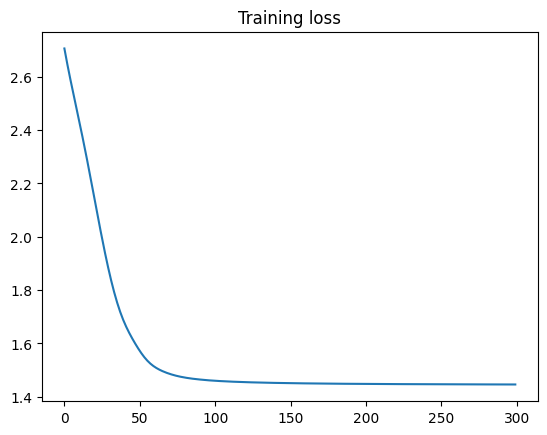

In [24]:
# define the neural network architecture
class W2WSG(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(num_embeddings=d, embedding_dim=p)
        self.linear = torch.nn.Linear(in_features=p, out_features=d, bias = False)

    def forward(self, x):
        e = self.embedding(x)
        z = self.linear(e)
        return z
    
# define an instande of the model class
w2w_sg = W2WSG()

# define an optimizer and loss
optimizer = torch.optim.Adam(lr = 0.02, params = w2w_sg.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

losses = []
epochs = 300
for epoch in range(epochs):
    w2w_sg.train()
    scores = w2w_sg(torch.tensor(X))
    batch_loss = loss_fn(scores, torch.tensor(y))
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

    losses.append(batch_loss.detach().numpy())

# visualize the training loss  
plt.plot(losses)
plt.title("Training loss")
plt.show()

In [25]:
word_embeddings = w2w_sg.linear.weight.detach().numpy()
word_embeddings_df = pd.DataFrame(cosine_similarity(word_embeddings), columns = list(word2index.keys()), index = list(word2index.keys()))
word_embeddings_df

,i,love,vanilla,ice,cream,strawberry,the,capitol,of,germany,is,berlin,france,paris
i,1.000000,0.980305,0.930899,0.999677,0.993644,0.961790,-0.157483,-0.993273,-0.377603,-0.132472,-0.993250,-0.055175,-0.070472,-0.045694
love,0.980305,1.000000,0.874670,0.985004,0.996305,0.889969,-0.345257,-0.996560,-0.191275,-0.323553,-0.996574,0.074752,-0.262292,0.028139
vanilla,0.930899,0.874670,1.000000,0.925877,0.903142,0.964473,0.101835,-0.900989,-0.465627,0.109433,-0.900807,-0.411485,0.182647,0.175095
ice,0.999677,0.985004,0.925877,1.000000,0.996181,0.954708,-0.181877,-0.995889,-0.354385,-0.157265,-0.995870,-0.038958,-0.095197,-0.035850
cream,0.993644,0.996305,0.903142,0.996181,1.000000,0.925492,-0.265436,-0.999987,-0.273383,-0.242143,-0.999985,0.019196,-0.180301,-0.004547
strawberry,0.961790,0.889969,0.964473,0.954708,0.925492,1.000000,0.118904,-0.924075,-0.594737,0.143388,-0.923981,-0.270951,0.205302,-0.089781
the,-0.157483,-0.345257,0.101835,-0.181877,-0.265436,0.118904,1.000000,0.269192,-0.777113,0.997830,0.269447,-0.775008,0.996113,-0.161679
capitol,-0.993273,-0.996560,-0.900989,-0.995889,-0.999987,-0.924075,0.269192,1.000000,0.271152,0.245723,1.000000,-0.024195,0.184096,0.006977
of,-0.377603,-0.191275,-0.465627,-0.354385,-0.273383,-0.594737,-0.777113,0.271152,1.000000,-0.810850,0.271055,0.466613,-0.822184,0.530057
germany,-0.132472,-0.323553,0.109433,-0.157265,-0.242143,0.143388,0.997830,0.245723,-0.810850,1.000000,0.245957,-0.740893,0.996756,-0.223090


### Practical considerations

CBOW aggregates context by summing or averaging context word vectors. This has a smoothing effect which may be helpful for smaller data sets. On the other side, it does not take full advantage of granular text information. As a consequence, it can be beneficial to use CBOW for smaller corpora and SG for larger ones. The embedding dimension is an important hyperparameter for the model. Choosing higher values may improve the understanding of similarity, while, at the same time, more data is needed to learn this. Common choices for larger and pre-trained models are in the range $[100, 300]$, however, sometimes embedding sizes go even higher. Another hyperparameter is the window size of the context. Common choices are between $5$ and $10$. Very frequent words can dominate the training of word embeddings. A common technique is to down-sample these words or even completely ignore them. At the same time words which appear very rarely may also be ignored because general relationships are hard to identify. Furthermore, training the model as a common multi-class classification problem can become cumbersome as the target dimension is equal to the number unique terms in the corpus. In practice, the model is usually trained by hierarchical softmax or negative sampling. This is beyond the scope of this course which is about the intuition how similar word embeddings are created for words with similar meaning.

## Working with word vectors

Once a Word2Vec model has been trained, we can generate numerical representations of words. An important side note is that a corpus usually is preprocessed before the model is trained. One central aspect of preprocessing is tokenization, i.e., the way each text is split into tokens which build the basis for creating a lexicon. Finally, each token in the lexicon will be mapped to a word embedding during the training process. This means, if we use, e.g., lower cases only, the word "Germany" will have no embedding because it is represented by the token "germany" after preprocessing. Consequently, if we process text in a different way than it has been done before training the model, we will receive many unknown token errors when we want to generate word embeddings. If we train our own model, this should be no problem because we can use the same tokenizer for handling text data after model training. However, if we use a pre-trained model and its embeddings, this may become a ciritical issue.

### Common usage

Nevertheless, let us start with a popular pre-trained model and its word embeddings: the [Google News embeddings](https://code.google.com/archive/p/word2vec/). They have been trained using the Google News dataset which includes about 100 billion words. The resulting model comes along with 300 dimensional vectors for 3 million words and phrases. What can we do with these vectors? The following common things come into mind:

* examine word similarities
* examine word analogies
* determine document embeddings
* visualize word embeddings

To determine word similarities, we compute a vector based similarity measure. The most popular choice in the natural language processing domain is the cosine similarity which has been presented in an earlier chapter of this book. For instance, the cell below shows the top ten similar words to the word "crisis":

In [26]:
import gensim.downloader

google_word_vectors = gensim.downloader.load('word2vec-google-news-300')
google_word_vectors.most_similar(positive = "crisis")

[('crises', 0.7838959693908691),
 ('turmoil', 0.6912833452224731),
 ('meltdown', 0.6789990067481995),
 ('credit_crunch', 0.6228187084197998),
 ('crisis.The', 0.6024228930473328),
 ('recession', 0.5982968211174011),
 ('downturn', 0.5976395010948181),
 ('subprime_mortgage_crisis', 0.5934383869171143),
 ('economic_downturn', 0.5829673409461975),
 ('liquidity_crunch', 0.5580255389213562)]

We observe cosine similarities in the range between $0.53$ and $0.63$. This brings up the question about the actual range of cosine similarities for all word embeddings. Due to the immense amount of words, we sample 10,000 words from the lexicon and determine their pairwise cosine similarities. The histogram below demonstrates that similarities seem to be roughly in the range $[-0.25, 0.80]$, even though values in the interval $[-1, 1]$ would be possible. This gives us a better understanding of common similarity levels for word pairs are. 

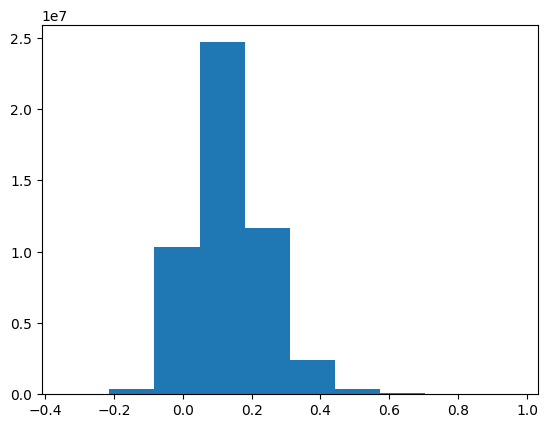

In [27]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pylab as plt
from sklearn.metrics.pairwise import cosine_similarity

# draw 10000 random vectors and determine their pairwise similarities to get an idea about the similarity range
rng = default_rng(seed = 42)
rnd_idx = rng.choice(len(google_word_vectors), size=10000, replace=False)
pairwise_similarities = cosine_similarity(google_word_vectors[rnd_idx]) 
pairwise_similarities_flat = pairwise_similarities[np.tril_indices(pairwise_similarities.shape[0], k = -1)]
plt.hist(pairwise_similarities_flat)
plt.show()

We also observe n-grams are included in the list of similar words. Usually, not all possible n-grams are taken into account, only very common combinations such as "New York". To identify common n-grams, one can, e.g., determine a score as suggested by [Mikolov et al. (2013)](https://arxiv.org/pdf/1310.4546):

$$
score(w_i, w_j) = \frac{count(w_i, w_j) - \delta}{count(w_i) \cdot count(w_j)}
$$

With $count(w_i, w_j), count(w_i), count(w_j)$ representing the number of co-occurrences for word pair $i,j$ and individual occurrences, respectively, and, $\delta$ a discounting coefficient. If a score exceeds a user-defined threshold, the pair is considered as a bi-gram. Repeating this counting process is also able to reveal n-grams of higher order.

The next impressive aspect of word embeddings is that we can use vector calculus to examine similarities and dissimilarities between words. The most popular example is the word analogy of "woman" to "man" which should be similar to "queen" and "king". Given the vectors $\boldsymbol{w}^{(woman)}, \boldsymbol{w}^{(man)}, \boldsymbol{w}^{(queen)}, \boldsymbol{w}^{(king)}$, we can calculate the differences $\boldsymbol{w}^{(woman)} - \boldsymbol{w}^{(man)}$ and $\boldsymbol{w}^{(queen)} - \boldsymbol{w}^{(king)}$. If the relation of woman to man is similar as the relation of queen to king, we should get:

$$
\boldsymbol{w}^{(woman)} - \boldsymbol{w}^{(man)} \approx \boldsymbol{w}^{(queen)} - \boldsymbol{w}^{(king)} 
$$

thus, 

$$
\boldsymbol{w}^{(woman)} - \boldsymbol{w}^{(man)} + \boldsymbol{w}^{(king)} 
$$

should be most similar to 

$$
\boldsymbol{w}^{(queen)}
$$

Let us find out:

In [28]:
google_word_vectors.similar_by_vector(google_word_vectors["woman"] - google_word_vectors["man"] + google_word_vectors["king"])

[('king', 0.8449392318725586),
 ('queen', 0.7300516366958618),
 ('monarch', 0.6454660296440125),
 ('princess', 0.6156251430511475),
 ('crown_prince', 0.5818676948547363),
 ('prince', 0.5777117609977722),
 ('kings', 0.5613663792610168),
 ('sultan', 0.5376776456832886),
 ('Queen_Consort', 0.5344247817993164),
 ('queens', 0.5289887189865112)]

Tadaa! This seems to work pretty good. Note, the calculation can also be done by the most_similar method, positive are the vectors with a positive sign, negative the ones with a negative sign:

In [29]:
google_word_vectors.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674735069275),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411403656006)]

If we can calculate with words, we can also average and sum word vectors. For instance, we can split a sentence into words and sum or average its word vectors to derive a sentence embedding. 

In [30]:
import pandas as pd

print("Tokenized sentences:")
print(f"{corpus} \n")
sentence_embeddings = [google_word_vectors.get_mean_vector(sentence) for sentence in corpus]
cosine_similarity_matrix = np.round(cosine_similarity(np.array(sentence_embeddings)), 4)
print("Pairwise cosine similarities:")
pd.DataFrame(cosine_similarity_matrix, index = [f"s{i+1}" for i in range(4)], columns = [f"s{i+1}" for i in range(4)])

Tokenized sentences:
[['i', 'love', 'vanilla', 'ice', 'cream'], ['i', 'love', 'strawberry', 'ice', 'cream'], ['the', 'capitol', 'of', 'germany', 'is', 'berlin'], ['the', 'capitol', 'of', 'france', 'is', 'paris']] 

Pairwise cosine similarities:


,s1,s2,s3,s4
s1,1.0000,0.9274,0.3028,0.3652
s2,0.9274,1.0000,0.3039,0.3514
s3,0.3028,0.3039,1.0000,0.8732
s4,0.3652,0.3514,0.8732,1.0000


Furthermore, we can build topic vectors which are calculated as the average of individual word vectors which represent a similar content. 

In [31]:
topic_words = ["environmental", "social", "governance"]
google_word_vectors.most_similar(topic_words)

[('ecological', 0.6291204690933228),
 ('corporate_governance_ESG', 0.6060682535171509),
 ('governance_ESG_issues', 0.6004064679145813),
 ('sustainablity', 0.5869180560112),
 ('environmental_sustainability', 0.5842981338500977),
 ('governance_ESG_factors', 0.5816299319267273),
 ('governance_ESG', 0.57416170835495),
 ('sustainability', 0.561872124671936),
 ('socio_economic', 0.5555124282836914),
 ('Melissa_McEver_covers', 0.5459955334663391)]

The only thing which is a little unfortunate is that we are not able to visualize how close certain word vectors are to others. This can be overcome by combining dimensionality reduction techniques with word embeddings. Different models can be used for dimensionality reduction. In general, dimensionality reduction tries to find lower dimensional representations of the original word vectors which keep as much of the original behavior as possible. 

*What dimensionality reduction techniques do*

We dot not discuss in this course how these methods work, however, the figure below demonstrates the functionality. In the left are observations from a fictional data set with 100 observations of two variables $x_1, x_2$. Three arbitrary observations are marked by the colors red, blue and green. Green and red are more close to each other than to blue. Thus, according to euclidean distance, green and red are more similar to each other than to blue. In the right, we observe a single variable which has been created out of the original two variables using a dimensionality reduction technique. Also in this one dimensional representation, the red and green observation are more close to each other than to the blue observations. Thus, this characteristic is not the same as before, but, kept as similar as possible. 

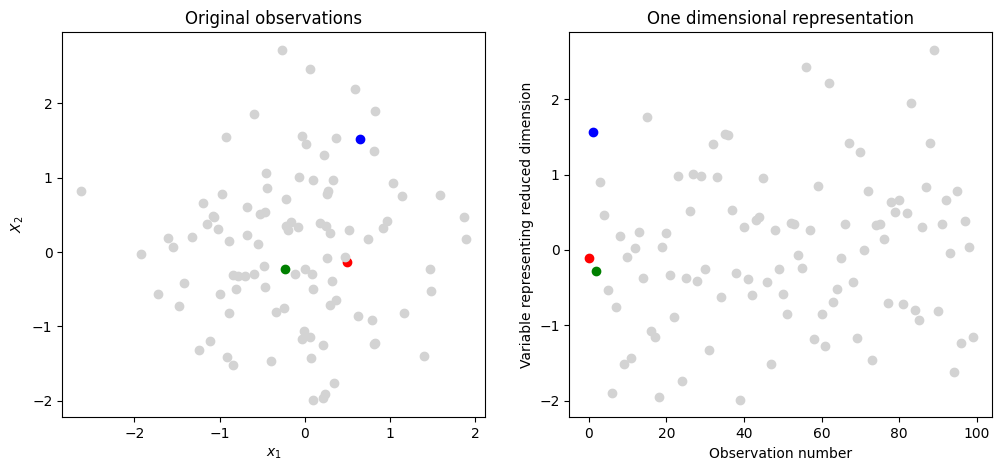

In [32]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.decomposition import PCA

np.random.seed(42)
X = np.random.normal(size = 200).reshape(100, 2)
pca = PCA(n_components=1)
x = pca.fit_transform(X)
colors = {i: "lightgray" for i in range(X.shape[0])}
colors[0] = "red"
colors[1] = "blue"
colors[2] = "green"

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
for i in range(X.shape[0]):
    axs[0].scatter(X[i, 0], X[i, 1], c = colors[i])
    axs[1].scatter(i, x[i], c = colors[i])
axs[0].set_title("Original observations")
axs[0].set_xlabel(r"$x_1$")
axs[0].set_ylabel(r"$X_2$")
axs[1].set_title("One dimensional representation")
axs[1].set_xlabel(r"Observation number")
axs[1].set_ylabel(r"Variable representing reduced dimension")
plt.show()

Below, we train the umap reduction model to a sample of 100,000 word vectors. 

In [33]:
import umap

dim_reducer = umap.UMAP(n_components=2, metric = "cosine")
rnd_idx = rng.choice(len(google_word_vectors), size=25000, replace=False)
dim_reducer.fit(google_word_vectors[rnd_idx])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP(angular_rp_forest=True, metric='cosine', tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

Now, we combine these techniques and plot two dimensional representations for similar and random words. In the example below, we look for the $20$ most similar words of the word "crisis". We generate two dimensional representations for the corresponding word vectors by transforming the original $300$ dimensional vectors with the umap dimensionality reduction model. The same thing is done for $100$ randomly selected words. The resulting vectors can be viszalized in the scatter plot below. 

In [34]:
import plotly.express as px

def plot_similar_words_2d(word, n_words, word_vectors, reducer, rnd_state = 42):
    most_sim_words = word_vectors.most_similar(word, topn = n_words)
    positive_words = word + [element[0] for element in most_sim_words]
    positive_words_2d = reducer.transform(word_vectors[positive_words])
    positive_words_2d_df = pd.DataFrame(positive_words_2d, index = positive_words, columns = ["u1", "u2"])
    positive_words_2d_df.loc[:, "category"] = "positive"

    positive_indices = [word_vectors.key_to_index[positive_word] for positive_word in positive_words]
    negative_indices = [i for i in range(len(word_vectors)) if not(i in positive_indices)]
    np.random.seed(rnd_state)
    negative_words_indices = np.random.choice(negative_indices, 5 * n_words, replace = False).tolist()
    negative_words = [word_vectors.index_to_key[negative_words_index] for negative_words_index in negative_words_indices]
    negative_words_2d = reducer.transform(word_vectors[negative_words_indices])
    negative_words_2d_df = pd.DataFrame(negative_words_2d, index = negative_words, columns = ["u1", "u2"])
    negative_words_2d_df.loc[:, "category"] = "negative"

    words_2d = pd.concat((positive_words_2d_df, negative_words_2d_df))

    fig = px.scatter(words_2d, x = "u1", y = "u2", color = "category", hover_name = words_2d.index, width = 800, height = 600, title = f"Similar and random words for the word(s): {word} in 2D")
    return fig

fig = plot_similar_words_2d(["crisis"], 20, google_word_vectors, dim_reducer)
fig.show()

### Performance evaluation for Word2Vec models

Two popular choices for evaluating the quality of word vectors are predefined analogy tasks as well as similarity tasks. The latter compute the correlation of pairwise word similarities made by humans and the ones derived by word embeddings. See below some examples for these tasks. In addition, another way to examine the quality of word embeddings is to use them for common natural language processing tasks and quantify the outcome. One of the most common sets of tasks is provided by the [General Language Understanding Evaluation (GLUE)](https://gluebenchmark.com/). However, if we are interested in domain specific performance, these considerations may not be most important to us. Given we train our word vectors mostly on, e.g., financial documents, it may be not surprising that these word embeddings may lack in their usage for general language understanding. However, they might be better in the representation of domain specific content. 

In [35]:
from gensim.test.utils import datapath

with open(datapath("questions-words.txt"), "r") as file:
    lines = file.readlines()

print("-"*50)
print("Examples for word analogy tasks:")
print("-"*50)

rng = default_rng(seed = 42)
rnd_idx = rng.choice(len(lines), size=5, replace=False)
for i, line in enumerate(lines):
    if i in rnd_idx:
        print(line)

with open(datapath("simlex999.txt"), "r") as file:
    lines = file.readlines()

print("-"*50)
print("Examples for human similarity:")
print("-"*50)
rnd_idx = rng.choice(len(lines), size=5, replace=False)
for i, line in enumerate(lines):
    if i in rnd_idx:
        print(line)

--------------------------------------------------
Examples for word analogy tasks:
--------------------------------------------------
Chisinau Moldova Ljubljana Slovenia

father mother son daughter

he she father mother

smart smartest quick quickest

Korea Korean Netherlands Dutch

--------------------------------------------------
Examples for human similarity:
--------------------------------------------------
unhappy	mad	5.95

whiskey	champagne	5.33

liquor	century	0.4

gun	fur	0.3

attach	join	7.75

